# Real Vs Fake Job Posting

#### Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import csv
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Defining functions for Sqlite

In [2]:
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
filename = "fake_job_postings.csv"

In [4]:
with open(filename) as file:
    raw_data = list(csv.reader(file, delimiter=","))
raw_data = raw_data[1:]
raw_data1 = [tuple(i) for i in raw_data]

In [5]:
db_file = 'raw_data.db'
import os
if os.path.exists(db_file):
    os.remove(db_file)
conn = create_connection(db_file)

create_table_sql1 = """
    CREATE TABLE IF NOT EXISTS [raw_data] (
        [job_id] integer not null primary key,
        [title] text,
        [location] text,
        [department] text,
        [salary_range] text,
        [company_profile] text,
        [description] text,
        [requirements] text,
        [benefits] text,
        [telecommuting] integer,
        [has_company_logo] integer,
        [has_questions] integer,
        [employment_type] text,
        [required_experience] text,
        [required_education] text,
        [industry] text,
        [function] text,
        [fraudulent] integer
    );
    """

def insert_raw_data(conn, values):
    sql = ''' INSERT INTO raw_data(job_id,title,location,
                department,salary_range,company_profile,description,
                requirements,benefits,telecommuting,has_company_logo,
                has_questions,employment_type,required_experience,
                required_education,industry,function,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

with conn:
        create_table(conn, create_table_sql1)
        for values in raw_data1:
            insert_raw_data(conn,values)

In [6]:
db_file_norm = 'normalized_data.db'
if os.path.exists(db_file_norm):
    os.remove(db_file_norm)
conn1 = create_connection(db_file_norm)

In [7]:
sql_statement = 'SELECT distinct company_profile, has_company_logo,count(job_id) from raw_data group by company_profile,has_company_logo order by company_profile'
df = pd.read_sql_query(sql_statement, conn)
display(df)

,company_profile,has_company_logo,count(job_id)
0,,0,2622
1,,1,686
2,Value Added Team of Creative ProfessionalsNet...,1,1
3,"""Only stupid questions create wealth"" - Gary ...",1,1
4,"""Our mission to our clients is to preserve the...",1,64
...,...,...,...
1706,Το #URL_bb79581a561837ad604b8fc4ab629753b36407...,1,4
1707,"УУРРАА - технологическая компания, работающая ...",1,9
1708,“News360 is Changing the Content Delivery Game...,1,1
1709,"“No surveys, social data can answer your quest...",1,1


In [8]:
l1 = df.iloc[2:,0].values
l1.shape

(1709,)

In [9]:
np.unique(l1).shape

(1709,)

In [10]:
sql_statement = 'SELECT distinct department, count(job_id) from raw_data group by department'
df = pd.read_sql_query(sql_statement, conn)
df.head(50)

,department,count(job_id)
0,,11547
1,,6
2,\tCorporate Shared Services,1
3,Lower Level Management,1
4,Marketing,1
5,Moni Technologies,1
6,R&D,1
7,(Consultant),1
8,.NET,1
9,.net Development,1


In [11]:
# with conn:
#     sql_statement = 'SELECT distinct title from raw_data'
#     value_profile = execute_sql_statement(sql_statement, conn)

sql_statement = """
    SELECT count(*) FROM raw_data WHERE (job_id+title+location+department+salary_range+company_profile+description+requirements+benefits+telecommuting+has_company_logo+has_questions+employment_type+required_experience+required_education+industry+function+fraudulent) = ' '
    """

df = pd.read_sql_query(sql_statement, conn)
df

,count(*)
0,0


- title - title
- department - distinct department
- salary - id, distinct salary(min max)
- description - description
- requirements - id, req
- benefits - id,benefits

- telecommuting
- has_company_logo
- has_questions
- employment_type - 
- required_experience
- required_education
- industry


- function
- fraudulent
------ job_title_loc: job_id, title, locid, titleid, salaryid
- company table: companyid, company_profile, has_company_logo
- location table: locid,location - seggregated
- jobid - companyid,  ###company_profile


- desc and company change
- posting: jobid,companyid, titleid,locID,deptID,salaryID, telecommuting,has_questions, employmentid, req_exp_id,req_edu_id,industryid,functionID, requirementID, benefitID,fraudulent



- DescriptionID, reqID, BenefitID, telecommuting, has_questions,employment_typeID,required_experience,required_education,industry,function
- 

In [12]:
with conn:
    sql_statement = 'SELECT distinct job_id,title,location,department,salary_range,company_profile,description,requirements,benefits from raw_data'
    raw_data = execute_sql_statement(sql_statement, conn)

In [13]:
job_idx = []
titles = []
depts = []
salaries = []
requirements = []
benefits = []

for data in raw_data:
    job_id = data[0]
    job_idx.append(job_id)
    
    title = data[1]
    titles.append((title,))
    
    dept = data[3]
    depts.append((dept,))
    
    salary_range = data[4]
    if '-' in salary_range:
        min_salary = salary_range.split('-')[0].split(' ')[0]
        max_salary = salary_range.split('-')[1].split(' ')[-1]
    else:
        min_salary = ''
        max_salary = ''
    salaries.append((salary_range, min_salary, max_salary))
    
    requirement = data[7]
    requirements.append((requirement,))
    
    benefit = data[8]
    benefits.append((benefit,))

titles = tuple(set(titles))
depts = tuple(set(depts))
salaries = tuple(set(salaries))
requirements = tuple(set(requirements))
benefits = tuple(set(benefits))

In [14]:
titles

(('Optician / Sales',),
 ('Copywriter -- Storyteller',),
 ('I want to be a Postgrad Intern at Vend!',),
 ('Manchester Apprenticeships Under NAS 16-24 Year Olds Only',),
 (' Onshore Scaffolding Coordinator',),
 ('Investor Development Intern 3 - 6 Months',),
 ('Dog Daycare Attendant',),
 ('Corporate Sales Representative ',),
 ('Software Developer .Net SQL Server',),
 ('Immediate Opening : Dotnet Developer ',),
 ('Sales Associate - Rippleshot',),
 ('Sales Development / Lead Generation',),
 ('Director of Engineering | HMA Security Products',),
 ('Financial Advisor',),
 ('Web Developer (m/f)',),
 ('Senior Sales Executive - Southeast',),
 ('Jr. Systems Administrator',),
 ('Hardware Lab Technician (Temp)',),
 ('Hotel Assistant General Manager',),
 ('PL15 Business Admin and Sales Apprenticeship Under NAS 16-18 Year Olds Only',),
 ('Lead Customer Service Associate ',),
 ('DISPOSITION TRAINEE',),
 ('Business Analyst - Web | Software Development',),
 ('Back-end Engineer ',),
 ('Life Insurance Age

In [15]:
def insert_titles(titles,conn):
    table_sql = """
                    CREATE TABLE [Titles] (
                        [TitleID] Integer not null primary key,
                        [Title] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Titles (Title)
                    Values (?)
                    """
    
    with conn:
        create_table(conn, table_sql, "Titles")
        cur.executemany(insert_sql, titles)
    return cur.lastrowid
    
def insert_departments(departments,conn):
    table_sql = """
                    CREATE TABLE [Departments] (
                        [DepartmentID] Integer not null primary key,
                        [Department] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Departments (Department)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Departments")
        cur.executemany(insert_sql, departments)
    return cur.lastrowid
    
def insert_salaries(salaries,conn):
    table_sql = """
                    CREATE TABLE [Salaries] (
                        [SalaryID] Integer not null primary key,
                        [Salary_Range] Text,
                        [Min_Salary] REAL,
                        [Max_Salary] REAL
                    );
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Salaries (Salary_Range, Min_Salary, Max_Salary)
                    Values (?,?,?)
                    """
    with conn:
        create_table(conn, table_sql, "Salaries")
        cur.executemany(insert_sql, salaries)
    return cur.lastrowid
    
def insert_requirements(requirements,conn):
    table_sql = """
                    CREATE TABLE [Requirements] (
                        [RequirementID] Integer not null primary key,
                        [Requirement] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Requirements (Requirement)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Requirements")
        cur.executemany(insert_sql, requirements)
    return cur.lastrowid
    
def insert_benefits(benefits,conn):
    table_sql = """
                    CREATE TABLE [Benefits] (
                        [BenefitID] Integer not null primary key,
                        [Benefit] Text
                    )
                    """
    
    cur = conn.cursor()
    insert_sql = """
                    INSERT INTO Benefits (Benefit)
                    Values (?)
                    """
    with conn:
        create_table(conn, table_sql, "Benefits")
        cur.executemany(insert_sql, benefits)
    return cur.lastrowid
    
insert_titles(titles,conn1)
insert_departments(depts,conn1)
insert_salaries(salaries,conn1)
insert_requirements(requirements,conn1)
insert_benefits(benefits,conn1)

In [16]:
with conn:
    sql_statement = 'SELECT distinct telecommuting from raw_data'
    value_telecommuting = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_telecommuting = """
    CREATE TABLE IF NOT EXISTS [Telecommuting] (
        [telecommutingId] integer not null primary key,
        [isTelecommuting] integer not null
    );
    """

def insert_telecommuting(conn, values):
    sql = ''' INSERT INTO Telecommuting(isTelecommuting) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_telecommuting,'Telecommuting')
    insert_telecommuting(conn1,value_telecommuting)
#     sql_statement = 'SELECT * from Telecommuting'
#     telecommuting = execute_sql_statement(sql_statement, conn1)

In [17]:
value_telecommuting

[(0,), (1,)]

In [18]:
with conn:
    sql_statement = 'SELECT distinct has_company_logo from raw_data'
    value_companylogo = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Companylogo] (
        [LogoId] integer not null primary key,
        [HasLogo] integer not null
    );
    """

def insert_companylogo(conn, values):
    sql = ''' INSERT INTO Companylogo(HasLogo) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Companylogo')
    insert_companylogo(conn1,value_companylogo)
#     sql_statement = 'SELECT * from Companylogo'
#     logo = execute_sql_statement(sql_statement, conn1)

In [19]:
with conn:
    sql_statement = 'SELECT distinct has_questions from raw_data'
    value_questions = execute_sql_statement(sql_statement, conn)
#     insert_tuple = []
#     for row in value_telecommuting:
#         if row[0] == 1:
#             insert_tuple.append((True,))
#         else :
#             insert_tuple.append((False,)) 
    
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [HasQuestions] (
        [QuestionId] integer not null primary key,
        [HasQuestion] integer not null
    );
    """

def insert_questions(conn, values):
    sql = ''' INSERT INTO HasQuestions(HasQuestion) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'HasQuestions')
    insert_questions(conn1,value_questions)
#     sql_statement = 'SELECT * from HasQuestions'
#     question = execute_sql_statement(sql_statement, conn1)

In [20]:
with conn:
    sql_statement = 'SELECT distinct employment_type from raw_data'
    value_employment_type = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [EmploymentTypes] (
        [EmploymentTypeId] integer not null primary key,
        [EmploymentType] text
    );
    """

def insert_eType(conn, values):
    sql = ''' INSERT INTO EmploymentTypes(EmploymentType) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'EmploymentTypes')
    insert_eType(conn1,value_employment_type)
#     sql_statement = 'SELECT * from EmploymentTypes'
#     employment_type = execute_sql_statement(sql_statement, conn1)

In [21]:
with conn:
    sql_statement = 'SELECT distinct required_experience from raw_data'
    value_required_experience = execute_sql_statement(sql_statement, conn)

    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredExperiences] (
        [RequiredExperienceId] integer not null primary key,
        [RequiredExperience] Text
    );
    """

def insert_req_experience(conn, values):
    sql = ''' INSERT INTO RequiredExperiences(RequiredExperience) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'RequiredExperience')
    insert_req_experience(conn1,value_required_experience)
#     sql_statement = 'SELECT * from RequiredExperiences'
#     experience_type = execute_sql_statement(sql_statement, conn1)

In [22]:
with conn:
    sql_statement = 'SELECT distinct required_education from raw_data'
    value_required_education = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [RequiredEducation] (
        [RequiredEducationId] integer not null primary key,
        [Education] Text
    );
    """

def insert_req_education(conn, values):
    sql = ''' INSERT INTO RequiredEducation(Education) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Education')
    insert_req_education(conn1,value_required_education)
#     sql_statement = 'SELECT * from RequiredEducation'
#     required_education = execute_sql_statement(sql_statement, conn1)

In [23]:
with conn:
    sql_statement = 'SELECT distinct industry from raw_data'
    value_industry = execute_sql_statement(sql_statement, conn) 
    
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Industry] (
        [IndustryId] integer not null primary key,
        [IndustryName] Text
    );
    """

def insert_Industry(conn, values):
    sql = ''' INSERT INTO Industry(IndustryName) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Industry')
    insert_Industry(conn1,value_industry)
#     sql_statement = 'SELECT * from Industry'
#     industry = execute_sql_statement(sql_statement, conn1)

In [24]:
with conn: 
    sql_statement = "SELECT distinct function from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [function] (
        [functionID] integer not null primary key,
        [function] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO function(function) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'function')
    for values in value_profile:
        insert_profile(conn1,values)

In [25]:
with conn: 
    sql_statement = "SELECT distinct fraudulent from raw_data where fraudulent != ''"
    value_fraudulent = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [fraudulent] (
        [fraudulent] integer not null primary key
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO fraudulent(fraudulent) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.execute(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'fraudulent')
    for values in value_fraudulent:
        insert_profile(conn1,values)

In [26]:
# with conn1: 
#     sql_statement = "DROP table Title"
#     execute_sql_statement(sql_statement, conn1)

In [27]:
# description - description

with conn: 
    sql_statement = "SELECT distinct description from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Description] (
        [DescriptionID] integer not null primary key,
        [Description] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Description(Description) 
                VALUES(?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Description')
    insert_profile(conn1,value_profile)

In [28]:
# Company

with conn: 
    sql_statement = "SELECT distinct company_profile,description,has_company_logo from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement = "SELECT DescriptionID,Description from Description"
    value_comp = execute_sql_statement(sql_statement, conn1)
comp_dict = {}
desc_list = []

for row in value_comp:
    key,text = row
    comp_dict[text] = key

for i in value_profile:
    for k1,v1 in comp_dict.items():
        if i[1] == k1:
            desc_list.append((i[0],i[2],v1))

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Company] (
        [CompanyID] integer not null primary key,
        [company_profile] text,
        [has_company_logo] integer,
        [DescriptionID] integer not null,
        Foreign key(DescriptionID) references Description(DescriptionID)
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Company(company_profile,has_company_logo,DescriptionID) 
                VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Company')
    insert_profile(conn1,desc_list)

In [35]:
# location table: locid,location - seggregated

with conn: 
    sql_statement = "SELECT distinct location from raw_data"
    value_profile = execute_sql_statement(sql_statement, conn)
    
list_country = []
list_state = []
list_city = []
list_loc1 = []
for i in value_profile:
    for j in i:
        list_loc1.append(j)
        if j.split(',')[0].strip() != '':
            list_country.append(j.split(',')[0].strip())
        else:
            list_country.append('')
        if len(j.split(','))!=1:
            if j.split(',')[1].strip() != '':
                list_state.append(j.split(',')[1].strip())
            else:
                list_state.append('')
        else:
            list_state.append('')
        if len(j.split(','))!=1:
            if j.split(',')[2].strip() != '':
                list_city.append(j.split(',')[2].strip())
            else:
                list_city.append('')
        else:
            list_city.append('')

list_loc = [(i,j,k,l) for i,j,k,l in zip(list_loc1,list_country,list_state,list_city)]

create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Location] (
        [LocationID] integer not null primary key,
        [Location] text not null,
        [Country] text not null,
        [State] text not null,
        [City] text not null
    );
    """

def insert_profile(conn, values):
    sql = ''' INSERT INTO Location(Location,Country,State,City) 
                VALUES(?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

   

with conn1:
    create_table(conn1, create_table_sql2,'Location')
    insert_profile(conn1,list_loc)

In [36]:
# posting: jobid,companyid, titleid,locID,salaryID, telecommuting,has_questions, 
# employmentid, req_exp_id,req_edu_id,industryid,functionID, requirementID, benefitID,fraudulent

# job_id,title,location,
#                 department,salary_range,company_profile,description,
#                 requirements,benefits,telecommuting,has_company_logo,
#                 has_questions,employment_type,required_experience,
#                 required_education,industry,function,fraudulent


with conn: 
    sql_statement = """SELECT distinct job_id,title,location,department,salary_range,
    company_profile,requirements,benefits,telecommuting, has_questions,
    employment_type,required_experience,required_education,industry,
    function,fraudulent from raw_data"""
    raw_data_post = execute_sql_statement(sql_statement, conn)
with conn1: 
    sql_statement1 = "SELECT TitleID,Title from Titles"
    value_title = execute_sql_statement(sql_statement1, conn1)
    sql_statement2 = "SELECT LocationID,Location from Location"
    value_loc = execute_sql_statement(sql_statement2, conn1)
    sql_statement3 = "SELECT DepartmentID,Department from Departments"
    value_dept = execute_sql_statement(sql_statement3, conn1)
    sql_statement4 = "SELECT SalaryID,Salary_Range from Salaries"
    value_sal = execute_sql_statement(sql_statement4, conn1)
    sql_statement5 = "SELECT CompanyID,company_profile from Company"
    value_comp = execute_sql_statement(sql_statement5, conn1)
    sql_statement6 = "SELECT RequirementID,Requirement from Requirements"
    value_req = execute_sql_statement(sql_statement6, conn1)
    sql_statement7 = "SELECT BenefitID,Benefit from Benefits"
    value_benefits = execute_sql_statement(sql_statement7, conn1)
    sql_statement8 = "SELECT EmploymentTypeId,EmploymentType from EmploymentTypes"
    value_emp = execute_sql_statement(sql_statement8, conn1)
    sql_statement9 = "SELECT RequiredExperienceId,RequiredExperience from RequiredExperiences"
    value_req_exp = execute_sql_statement(sql_statement9, conn1)
    sql_statement10 = "SELECT RequiredEducationId,Education from RequiredEducation"
    value_req_edu = execute_sql_statement(sql_statement10, conn1)
    sql_statement11 = "SELECT IndustryID,IndustryName from Industry"
    value_ind = execute_sql_statement(sql_statement11, conn1)
    sql_statement12 = "SELECT functionID,function from function"
    value_func = execute_sql_statement(sql_statement12, conn1)



def create_list_posting(raw_data_post,value,n):
    value_dict = {}
    post_list = []
    for row in value:
        key,text = row
        value_dict[text] = key

    for i in raw_data_post:
        for k1,v1 in value_dict.items():
            if i[n] == k1:
                post_list.append((i[0],v1))
    return post_list

title_list = create_list_posting(raw_data_post,value_title,1)
loc_list = create_list_posting(raw_data_post,value_loc,2)
dept_list = create_list_posting(raw_data_post,value_dept,3)
sal_list = create_list_posting(raw_data_post,value_sal,4)
comp_list = create_list_posting(raw_data_post,value_comp,5)
req_list = create_list_posting(raw_data_post,value_req,6)
benefits_list = create_list_posting(raw_data_post,value_benefits,7)
emp_list = create_list_posting(raw_data_post,value_emp,10)
exp_list = create_list_posting(raw_data_post,value_req_exp,11)
edu_list = create_list_posting(raw_data_post,value_req_edu,12)
ind_list = create_list_posting(raw_data_post,value_ind,13)
func_list = create_list_posting(raw_data_post,value_func,14)



In [40]:
dict_post = {}

def append_list(dict_post,list_x):
    for record in list_x:
        dict_post[record[0]] = dict_post.get(record[0],[])
        dict_post[record[0]].append(record[1])
    return dict_post

for i in (title_list,loc_list,dept_list,sal_list,comp_list,req_list,benefits_list,emp_list,exp_list,edu_list,ind_list,func_list):
    dict_post = append_list(dict_post,i)


In [51]:
post_list = []
for k,v in dict_post.items():
    for i in raw_data_post:
        if i[0] == k:
            post_list.append((i[0],v[0],v[1],v[2],v[3],v[4],v[5],v[6],i[8],i[9],v[7],v[8],v[9],v[10],v[11],i[15]))


In [54]:
create_table_sql2 = """
    CREATE TABLE IF NOT EXISTS [Posting] (
        [job_id] integer not null primary key,
        [TitleID] integer,
        [LocationID] integer,
        [DepartmentID] integer,
        [SalaryID] integer,
        [CompanyID] integer,
        [RequirementID] integer,
        [BenefitID] integer,
        [telecommuting] integer,
        [has_questions] integer,
        [EmploymentTypeId] integer,
        [RequiredExperienceId] integer,
        [RequiredEducationId] integer,
        [IndustryID] integer,
        [functionID] integer,
        [fraudulent] integer,
        Foreign key(TitleID) references Titles(TitleID),
        Foreign key(LocationID) references Location(LocationID),
        Foreign key(DepartmentID) references Departments(DepartmentID),
        Foreign key(SalaryID) references Salaries(SalaryID),
        Foreign key(CompanyID) references Company(CompanyID),
        Foreign key(RequirementID) references Requirements(RequirementID),
        Foreign key(BenefitID) references Benefits(BenefitID),
        Foreign key(EmploymentTypeId) references EmploymentTypes(EmploymentTypeId),
        Foreign key(RequiredExperienceId) references RequiredExperiences(RequiredExperienceId),
        Foreign key(RequiredEducationId) references RequiredEducation(RequiredEducationId),
        Foreign key(IndustryID) references Industry(IndustryID),
        Foreign key(functionID) references function(functionID)
    );
    """

def insert_posting(conn, values):
    sql = ''' INSERT INTO Posting(job_id,TitleID,LocationID,DepartmentID,
    SalaryID,CompanyID,RequirementID,BenefitID,telecommuting,has_questions,EmploymentTypeId,
    RequiredExperienceId,RequiredEducationId,IndustryID,functionID,fraudulent) 
                VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid



In [55]:

with conn1:
    create_table(conn1, create_table_sql2,'Posting')
    insert_posting(conn1,post_list)

In [56]:
sql_show_tables = """SELECT name FROM sqlite_master  
WHERE type='table'"""
res = execute_sql_statement(sql_show_tables,conn1)
print(res)

[('Titles',), ('Departments',), ('Salaries',), ('Requirements',), ('Benefits',), ('Telecommuting',), ('Companylogo',), ('HasQuestions',), ('EmploymentTypes',), ('RequiredExperiences',), ('RequiredEducation',), ('Industry',), ('function',), ('fraudulent',), ('Description',), ('Company',), ('Location',), ('Posting',)]


# Exploratory Data Analysis

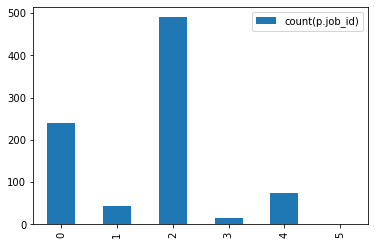

In [89]:
sql_statement_eda = """
select
CASE e.EmploymentType
        WHEN '' THEN 'Unknown'
        ELSE e.EmploymentType
    END EmploymentType,
    count(p.job_id) from EmploymentTypes e
inner join Posting p
on e.EmploymentTypeId = p.EmploymentTypeId
where p.fraudulent = 1
group by EmploymentType
"""
df = pd.read_sql_query(sql_statement_eda,conn1)
df.plot.bar()
plt.show()